In [ ]:
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from colossus.cosmology import cosmology
from colossus.halo import profile_base
from colossus.halo import mass_so
from colossus.halo import profile_spline
from colossus.halo import profile_nfw
cosmo = cosmology.setCosmology('planck18')
from colossus.halo import profile_einasto
from colossus.halo import profile_diemer22

In [ ]:
# Considerando um halo com M_200 = 5x10^14
Mvir = 5*10**14
# Consultando Duffy et al. (2008) vemos qual deve ser a concentração c desse halo, supondo z = redshift =  0
cvir = 4.2
z = 0

#Constate Gravitacional
Gc = 4.30091*(10**(-3)) *u.pc*(u.Msun**-1)*(u.km)**2/(u.s)**2
#Constante de Hubble na Unidade km/kpc*s
H0 = cosmo.H(0).to(u.km / (u.kpc*u.s))

rho_crit = (3*(H0**2))/(8*np.pi*Gc)
rho_crit = rho_crit.to(u.Msun/u.kpc**3)

# Calculando o raio do Virial
r200 = (3*Mvir/(800*np.pi*rho_crit))**(1/3)

p_nfw = profile_nfw.NFWProfile

(1.0, 100000000.0)

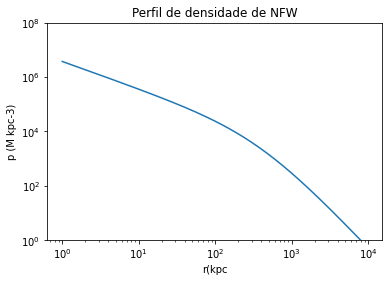

In [5]:
# Fazendo o gráfico do perfil de desnidade de NFW com os parâmetros selecionados
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')

r = 10**np.arange(0,4,0.02)
rho_m = cosmo.rho_m(z)
rho_nfw = p_nfw.density(r)

plt.figure()
plt.loglog()
plt.title("Perfil de densidade de NFW")
plt.xlabel('r(kpc')
plt.ylabel('p (M kpc-3)')
plt.plot(r, rho_nfw / rho_m, '-')
plt.ylim(1E0, 1E8)


In [6]:
# Agora para obter o comprimento de escala ah do perfil de Hernquist de mesma massa Mh = M200.
# Aqui basta aplicarmos a fomrula da igualdade dos perfis de NFW e e perfil de Hernquist (deduzido no exercicio 5 desta lista)
rs = 391
a_h = rs * 1.296893456
print("O comprimento de escala ah = ", a_h)

O comprimento de escala ah =  507.085341296


In [7]:
# Crinado uma class com os dados de Hernquist para justamente fazer a comparação entre ambos os perfis de densidade
class HernquistProfile(profile_base.HaloDensityProfile):

    def __init__(self, **kwargs):

        self.par_names = ['rhos', 'rs']
        self.opt_names = []
        profile_base.HaloDensityProfile.__init__(self, **kwargs)

        return
    def densityInner(self, r):

        x = r / self.par['rs']
        density = self.par['rhos'] / x / (1.0 + x)**3

        return density
    
    def setNativeParameters(self, M, c, z, mdef, **kwargs):

        self.par['rs'] = mass_so.M_to_R(M, z, mdef) / c
        self.par['rhos'] = M / (2 * np.pi * rs**3) / c**2 * (1.0 + c)**2

        return

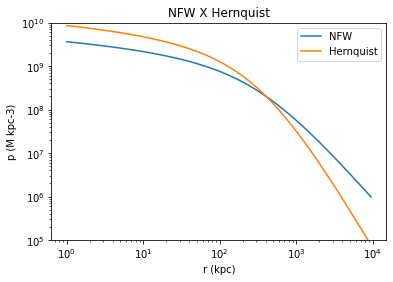

In [8]:
# Criando um gráfico de comparação entre os dois perfis densidade NFW e Hernquist
p_hernquist = HernquistProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')

r = 10**np.arange(0,4,0.02)
Sigma_hernquist = p_hernquist.surfaceDensity(r)
Sigma_nfw = p_nfw.surfaceDensity(r) 


plt.figure()
plt.loglog()
plt.title("NFW X Hernquist")
plt.xlabel('r (kpc)')
plt.ylabel('p (M kpc-3)')
plt.plot(r, Sigma_nfw, '-', label = 'NFW');

plt.plot(r, Sigma_hernquist, '-', label = 'Hernquist');
plt.ylim(1E5, 1E10)
plt.legend();

In [17]:
# Agora partimos para encotrar o perfil de densidade do gás .Para estabelecer a massa total de gás, adote uma fração de bárions global de 15%.
# Então por primeiro vamos calcular o total de massa aproximada usando a fração de gás
# Que pode ser calculada como frac_gas = Massa_gas / Massa_total (pode ser encontrada pg. https://ri.ufs.br/jspui/bitstream/riufs/11000/2/TARCISIO_ALVES_ARAUJO_BARRETO.pdf):
f_gas = 15/100
M_gas = (Mvir) * f_gas

#  Encontre o valor do comprimento de escala ag do perfil de Dehnen (com γ = 0), de tal modo que o perfil de densidade do gás seja comparável a um B-model com os seguintes parâmetros:
n_e = 5*10**-3 #cm−3
rc = 100 #Kpc
β = 0.7

# Pronto agora vamos atrás do peso molecular médio µe é definido como a massa média por elétron livre:
# Pode ser calculado usando u_e = 2/(1+x)
# Para um gás totalmente ionizado temos como variaves X,Y,Z, mas como estamos considerando z=0, então y= 1-x, então
x= 0.76
#Então
u_e = 2/(1+x)
u_e
# Portanto a densidade central que corresponde ao n_e , calcuando usando
# u_e = ρ/n_e.Mh -> dado é:
p_o = 1.3*10**5

# Agora calculando o perfil do B-model tem termos do raio esferico r:
p_b = p_o / (1 + (r/rc)**2)**(3*β/2)

# Agora basta calcularmos o comprimeto de escala usando o p_o e o B-model:
a_g = ((3*M_gas)/ (4*math.pi*p_o))**(1/3)
a_g

516.4279835805529

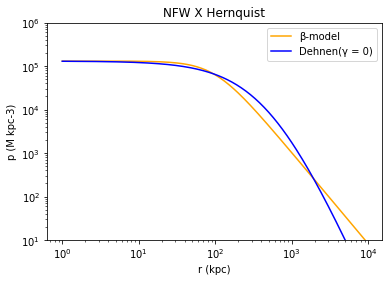

In [20]:
#  Vamos adotar γ = 0, pois assim temos um core de densidade constante que se assemelha ao core do β-model:
p_g = ((3*M_gas)/(4*math.pi)) * (a_g/(r+a_g)**4)

# Fazendo o plot de dos dois perfis:

plt.figure()
plt.loglog()
plt.title("NFW X Hernquist")
plt.xlabel('r (kpc)')
plt.ylabel('p (M kpc-3)')
plt.plot(r, p_b, '-', label = 'β-model', color = 'orange')
plt.plot(r, p_g, '-', label = 'Dehnen(γ = 0)', color = 'blue')

plt.ylim(1E1, 1E6)

plt.legend()


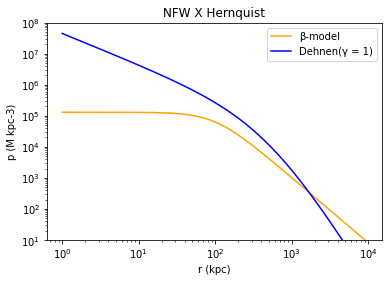

In [21]:
# Usando y = 1

p_g_1 = ((2*M_gas)/(4*math.pi))*((a_g)/(r*1 * (r+a_g)**3))

plt.figure()
plt.loglog()
plt.title("NFW X Hernquist")
plt.xlabel('r (kpc)')
plt.ylabel('p (M kpc-3)')
plt.plot(r, p_b, '-', label = 'β-model', color = 'orange')
plt.plot(r, p_g_1, '-', label = 'Dehnen(γ = 1)', color = 'blue')

plt.ylim(1E1, 1E8)

plt.legend()

In [ ]:
# Então para calcular a fração ed Barions basta usar a  massa total e a massa do gás em função de r 
gamma = 0
massa_tot = lambda r: ((M_gas*((r/(r+a_g))**(3-gamma)))+(Mvir*((r/(r+a_h))**2)))
m1 = massa_tot(r)

Mss_gas_t = lambda r: M_gas*((r/(r+a_g))**(3-gamma))
m2 = M_gas(r)

f_baryons = m2/m1

plt.plot(r,f_baryons,'-')
plt.title('Fração de Barions')
plt.xlabel('r(kpc)')
plt.ylabel('Fração de Barions')
plt.xscale('log')
plt.show()

In [ ]:
# Para calcular o  gráfico de T (r) em unidades de keV
# Usamos as cosntantes X,Y e Z para encontrar mu
X = 0.7
Y = 0.3
Z = 0.00
# Valor da cosntante G gravitacional
G = 4.30091*(10**(-3))
#Constante de Boltzmann
k = 1.381e-23
# Aplicando na formula
mu = X*(2/1)+Y*(3/4)+Z*(1/2)
mu = mu**-1

# Fazendo a integral em relação a T(r)
def integrand(r):

    return ((((3-gamma)*M_gas)/(4*np.pi))*((a_g)/((r**gamma)*((r+a_g)**(4-gamma)))))*((G*(((M_gas*((r/(r+a_g))**(3-gamma)))+(Mvir*((r/(r+a_h))**2)))))/(r**2))

In [ ]:
#mx = 2.36363*1E7
mx = 1.674e-27
#Constante A:
A = (mu*mx)/k
#B(r)
B0 = lambda r: 1/((((3-gamma)*M_gas)/(4*np.pi))*((a_g)/((r**gamma)*((r+a_g)**(4-gamma)))))
B1 = B0(r)
#C(r')
C = [quad(integrand,y,np.Infinity)[0] for y in r]
#S(r) = B1(r) * C(r')
S = np.multiply(B1,C)
#T(r) = A*S
T = np.multiply(S,A)

In [ ]:
# Plotando o gráfico T(r) para gamma = 0 

y7 = T*8.61732814974056E-05
r = np.linspace(1,r200,1647)
plt.plot(r,y7,'-')
plt.title('Perfil de Temperatura')
plt.xlabel('r(kpc)')
plt.ylabel('T(Kev)')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [ ]:
# Agora plotando para gamma = 1
gamma_1 = 1
# Para calcular o  gráfico de T (r) em unidades de keV
# Usamos as cosntantes X,Y e Z para encontrar mu
X = 0.7
Y = 0.3
Z = 0.00
# Valor da cosntante G gravitacional
G = 4.30091*(10**(-3))
#Constante de Boltzmann
k = 1.381e-23
# Aplicando na formula
mu = X*(2/1)+Y*(3/4)+Z*(1/2)
mu = mu**-1

# Fazendo a integral em relação a T(r)
def integrand(r):

    return ((((3-gamma_1)*M_gas)/(4*np.pi))*((a_g)/((r**gamma_1)*((r+a_g)**(4-gamma_1)))))*((G*(((M_gas*((r/(r+a_g))**(3-gamma_1)))+(Mvir*((r/(r+a_h))**2)))))/(r**2))

#mx = 2.36363*1E7
mx = 1.674e-27
#Constante A:
A = (mu*mx)/k
#B(r)
B0 = lambda r: 1/((((3-gamma_1)*M_gas)/(4*np.pi))*((a_g)/((r**gamma_1)*((r+a_g)**(4-gamma_1)))))
B1 = B0(r)
#C(r')
C = [quad(integrand,y,np.Infinity)[0] for y in r]
#S(r) = B1(r) * C(r')
S = np.multiply(B1,C)
#T(r) = A*S
T = np.multiply(S,A)

# Plotando o gráfico T(r) para gamma = 0 

t_r = T*8.61732814974056E-05
r = np.linspace(1,r200,1647)
plt.plot(r,t_r,'-')
plt.title('Perfil de Temperatura')
plt.xlabel('r(kpc)')
plt.ylabel('T(Kev)')
#plt.xscale('log')
#plt.yscale('log')
plt.show()